## 📘 Project Phase: Final Model Expansion

In this notebook, I will build on the previously improved XGBoost model (which achieved an RMSLE of 0.2381) by integrating additional data sources provided in the competition:

- `stores.csv` – store-level metadata (e.g. city, type, cluster)
- `oil.csv` – daily oil prices (macroeconomic signal)
- `transactions.csv` – store-level daily customer volume

### 🛠️ Planned Steps:
1. **Merge external datasets** into the training and test sets.
2. **Engineer new features** from these sources (e.g. oil trends, transaction lags).
3. **Refine the model** by re-tuning hyperparameters using TimeSeriesSplit CV.
4. **Evaluate** the impact of the new data on forecast accuracy (RMSLE).
5. **Re-train on full data** and prepare final Kaggle submission.

The goal is to push the model beyond current performance by capturing more contextual and behavioral signals.

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
pd.set_option("display.max_columns", None)

In [457]:
df = pd.read_csv("train.csv", parse_dates=['date'])
df.set_index('date', inplace=True)

holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
holidays.set_index('date', inplace=True)

oil_price = pd.read_csv('oil.csv', parse_dates=['date'])
oil_price.set_index('date', inplace=True)

stores = (
    pd.read_csv("stores.csv")
      .rename(columns={"type": "store_type"})
)

transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
transactions.set_index('date', inplace=True)

In [458]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

In [459]:
df = df.sort_values(['store_nbr', 'family'])

group_cols = ['store_nbr', 'family']
g = df.groupby(group_cols)['sales']


for d in [1, 7, 14, 28, 56]:
    df[f'lag_{d}'] = g.shift(d)


for w in ['7D', '14D']:
    name = f'rolling_{w[:-1]}_mean'
    df[name] = (
        g.apply(lambda s: s.shift(1).rolling(w).mean())
          .reset_index(level=group_cols, drop=True)
    )

In [460]:
oil_filled = (
  oil_price
    .asfreq("D")
    .ffill()
    .bfill()
    )

In [461]:
df = (
    df
    .reset_index()
    .merge(
        oil_filled.reset_index(),
        on="date",
        how="left"
    )
    .set_index("date")
)

In [462]:
df = (
    df
    .reset_index()
    .merge(
        holidays.reset_index(),
        on="date",
        how="left"
    )
    .set_index("date")
)

In [463]:
df['is_holiday'] = df['type'].notna().astype(int)
cols = ['type','locale','locale_name','description']
df[cols] = df[cols].fillna('NO_HOLIDAY')
df['transferred'] = df['transferred'].fillna(0).astype(int)

In [464]:
df = (
    df
    .reset_index()
    .merge(
        stores.reset_index(),
        on="store_nbr",
        how="left"
    )
    .set_index("date")
)

In [465]:
df = (
    df.reset_index()
      .merge(
          transactions,
          on=["date", "store_nbr"],
          how="left"
      )
      .set_index("date")
)

In [466]:
df["transactions"] = (
    df.groupby("store_nbr")["transactions"]
      .transform(lambda s: s.ffill().bfill())
)

In [467]:
lag_rolling_cols = [
    'lag_1', 'lag_7', 'lag_14', 'lag_28', 'lag_56',
    'rolling_7_mean', 'rolling_14_mean'
]
df = df.dropna(subset=lag_rolling_cols)

In [468]:
df.head()

,id,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,is_weekend,lag_1,lag_7,lag_14,lag_28,lag_56,rolling_7_mean,rolling_14_mean,dcoilwtico,type,locale,locale_name,description,transferred,is_holiday,index,city,state,store_type,cluster,transactions
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-26,99792,1,AUTOMOTIVE,0.0,0,2013,2,26,1,0,1.0,4.0,0.0,2.0,0.0,2.000000,1.285714,92.63,NO_HOLIDAY,NO_HOLIDAY,NO_HOLIDAY,NO_HOLIDAY,0,0,0,Quito,Pichincha,D,13,1804.0
2013-02-27,101574,1,AUTOMOTIVE,2.0,0,2013,2,27,2,0,0.0,2.0,0.0,6.0,2.0,1.428571,1.285714,92.84,NO_HOLIDAY,NO_HOLIDAY,NO_HOLIDAY,NO_HOLIDAY,0,0,0,Quito,Pichincha,D,13,1845.0
2013-02-28,103356,1,AUTOMOTIVE,1.0,0,2013,2,28,3,0,2.0,1.0,0.0,0.0,3.0,1.428571,1.428571,92.03,NO_HOLIDAY,NO_HOLIDAY,NO_HOLIDAY,NO_HOLIDAY,0,0,0,Quito,Pichincha,D,13,1763.0
2013-03-01,105138,1,AUTOMOTIVE,2.0,0,2013,3,1,4,0,1.0,2.0,0.0,3.0,3.0,1.428571,1.500000,90.71,NO_HOLIDAY,NO_HOLIDAY,NO_HOLIDAY,NO_HOLIDAY,0,0,0,Quito,Pichincha,D,13,1916.0
2013-03-02,106920,1,AUTOMOTIVE,1.0,0,2013,3,2,5,1,2.0,4.0,1.0,0.0,5.0,1.428571,1.642857,90.71,Holiday,Local,Manta,Fundacion de Manta,0,1,0,Quito,Pichincha,D,13,1332.0


In [469]:
cols = ['type','locale','locale_name','description']
df[cols] = df[cols].fillna('NO_HOLIDAY')

In [470]:
def encode_columns(df, columns, placeholder="NO_HOLIDAY"):
    for col in columns:
        mask = df[col] == placeholder

        le = LabelEncoder()
        le.fit(df.loc[~mask, col].astype(str))

        df.loc[~mask, col] = le.transform(df.loc[~mask, col].astype(str)) + 1

        df.loc[mask, col] = 0

        df[col] = df[col].astype(int)

    return df

In [471]:
cols = ['type','locale','locale_name','description']
df[cols] = df[cols].fillna('NO_HOLIDAY')

In [472]:
df = encode_columns(df, cols)

In [473]:
for col in ["city", "state", "store_type"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [474]:
cutoff_date = "2017-07-15"

In [475]:
train_df = df[df.index < cutoff_date]
val_df   = df[df.index >= cutoff_date]

In [476]:
X_train = train_df.drop(['sales', 'id', 'family'], axis=1)
y_train = train_df['sales']

In [477]:
X_val = val_df.drop(['sales', 'id', 'family'], axis=1)
y_val = val_df['sales']

In [478]:
model = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.1,
    max_depth = 7,
    reg_alpha = 0,
    reg_lambda = 0.5,
    subsample = 1.0,
    colsample_bytree = 0.8,
    random_state = 42,
    verbosity = 0,
    tree_method      = "gpu_hist"
)

In [479]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [480]:
y_fit  = model.predict(X_train)
y_pred = model.predict(X_val)

In [481]:
mae = mean_absolute_error(y_train, y_fit)

print(f"Training MAE: {mae:.2f}")

Training MAE: 39.27


In [482]:
test_mae = mean_absolute_error(y_val, y_pred)
print(f"Test MAE: {test_mae:.2f}")

Test MAE: 56.04


In [483]:
model = XGBRegressor(
    n_estimators = 1000,
    learning_rate = 0.1,
    max_depth = 7,
    reg_alpha = 0,
    reg_lambda = 0.5,
    subsample = 1.0,
    colsample_bytree = 0.8,
    random_state = 42,
    verbosity = 0,
    tree_method = "gpu_hist",
    early_stopping_rounds = 50
)

In [484]:
model.fit(X_train, y_train,
          eval_set = [(X_train, y_train), (X_val, y_val)],
          verbose = True)

[0]	validation_0-rmse:1012.30670	validation_1-rmse:1165.22607
[1]	validation_0-rmse:920.41774	validation_1-rmse:1049.89817
[2]	validation_0-rmse:837.52554	validation_1-rmse:948.45099
[3]	validation_0-rmse:763.48797	validation_1-rmse:858.63850
[4]	validation_0-rmse:697.85355	validation_1-rmse:777.43775
[5]	validation_0-rmse:640.31694	validation_1-rmse:704.24941
[6]	validation_0-rmse:588.24442	validation_1-rmse:638.66033
[7]	validation_0-rmse:542.01314	validation_1-rmse:580.39920
[8]	validation_0-rmse:501.48636	validation_1-rmse:528.60603
[9]	validation_0-rmse:465.10306	validation_1-rmse:483.13617
[10]	validation_0-rmse:433.30284	validation_1-rmse:443.32893
[11]	validation_0-rmse:405.37558	validation_1-rmse:408.27441
[12]	validation_0-rmse:380.60925	validation_1-rmse:376.69639
[13]	validation_0-rmse:359.34467	validation_1-rmse:350.21121
[14]	validation_0-rmse:340.74009	validation_1-rmse:326.64579
[15]	validation_0-rmse:324.96315	validation_1-rmse:306.11683
[16]	validation_0-rmse:310.9370

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [485]:
from sklearn.metrics import mean_squared_log_error
rmsle = mean_squared_log_error(y_val, np.clip(y_pred, 0, None))
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 0.2530


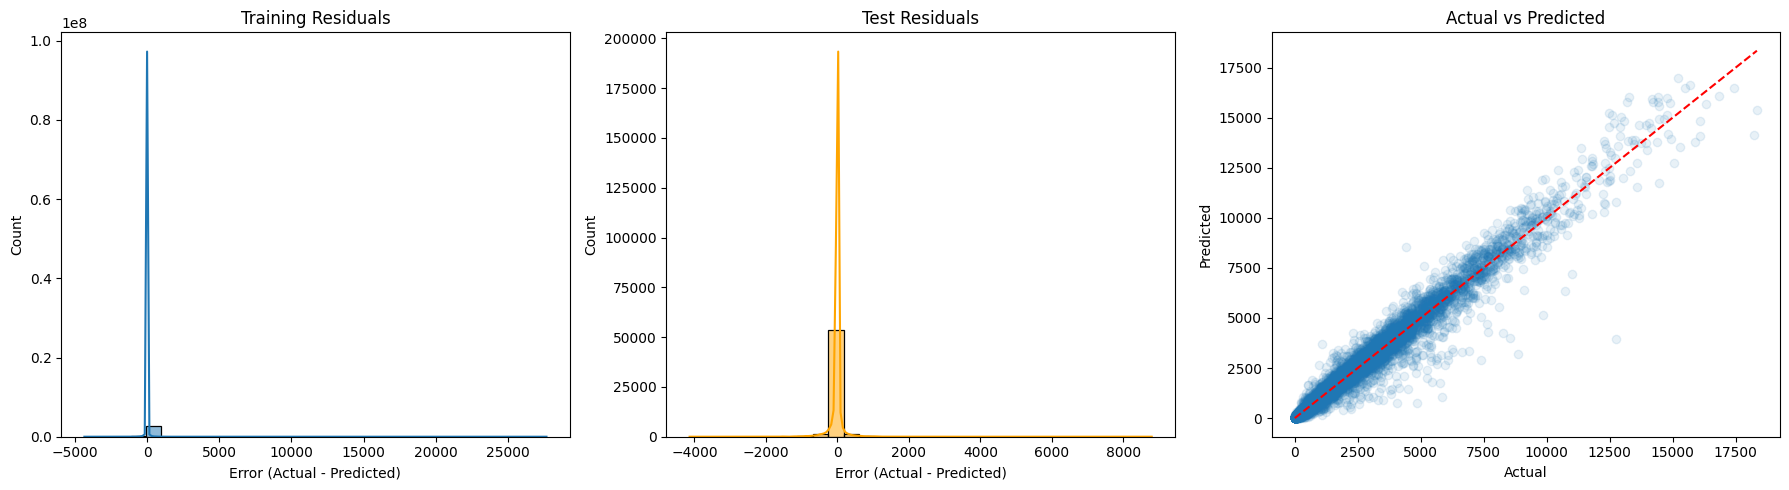

In [486]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(y_train - y_fit, bins=30, kde=True)
plt.title("Training Residuals")
plt.xlabel("Error (Actual - Predicted)")


plt.subplot(1, 3, 2)
sns.histplot(y_val - y_pred, bins=30, kde=True, color='orange')
plt.title("Test Residuals")
plt.xlabel("Error (Actual - Predicted)")


plt.subplot(1, 3, 3)
plt.scatter(y_val, y_pred, alpha=0.1)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

plt.tight_layout()
plt.show()

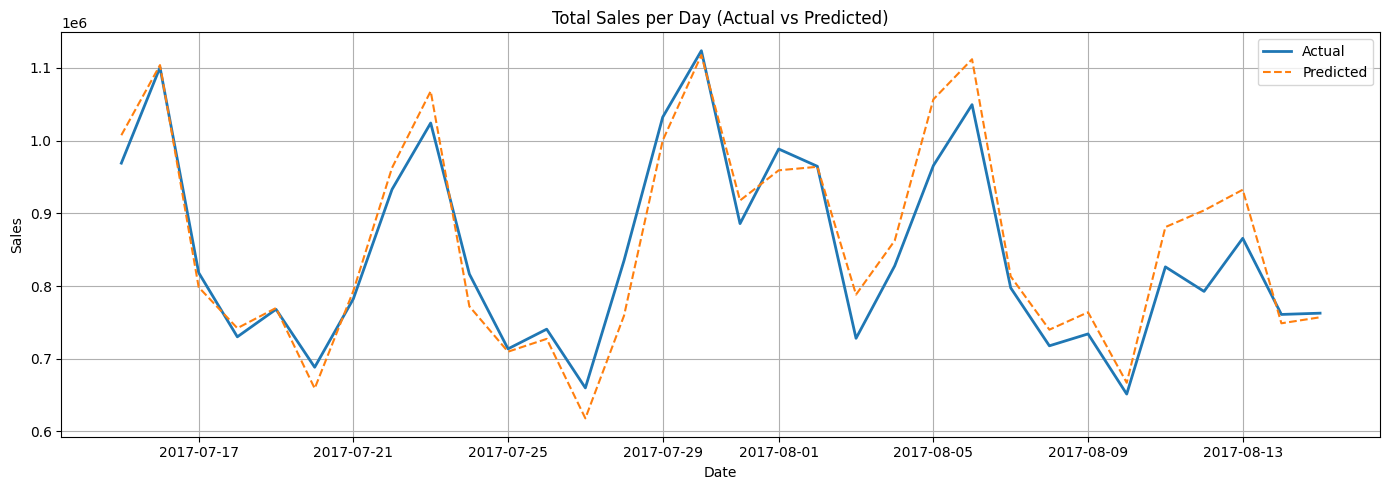

In [487]:
plot_df = val_df.copy()
plot_df["predicted"] = y_pred
plot_df["actual"] = y_val

# Group by date and sum to collapse across all store/family combos
daily = plot_df.groupby("date")[["actual", "predicted"]].sum()

# Plot
plt.figure(figsize=(14,5))
plt.plot(daily.index, daily["actual"], label="Actual", linewidth=2)
plt.plot(daily.index, daily["predicted"], label="Predicted", linestyle="--")
plt.title("Total Sales per Day (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()